In [63]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
import threading
import time
import math
import scipy as sp
from datetime import datetime

## Group Assignment
### Team Number: 08
### Team Member Names: Richard Meng, Avaansh Nanda, Devesh Kotak
### Team Strategy Chosen: Market Beat

We first start by reading the CSV file of tickers and processing the tickers as a list for easy iteration.

Graph #1: 
Make a graph that is superimposing the alpha, sharpe and general score
Graph #2: 
Make a graph of the market cap for each stock in the optimal portfolio
Graph #3: 
Weights of each stock for our optimized portfolio 
Graph #4:
Pie Chart for break up of all industries 

In [64]:
# read in the csv file and set the header to none, otherwise it will treat the first ticker as the header
tickers_csv = pd.read_csv("Tickers_Example.csv", header=None)
# turn the csv dataframe into a list
tickers = list(tickers_csv[0])
tickers

['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'AGN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BB.TO',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CELG',
 'CL',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MON',
 'MRK',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RTN',
 'RY.TO',
 'SHOP.TO',
 'T.TO',
 'TD.TO',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB',
 'COHU']

Below are some helper functions to help assist filtering our stock data using data threading. 

In [65]:
#  We will be filtering 40 tickers. Each thread will handle 5 tickers which download from yfinance simultaneously, speeding up the process.
START_DATE = "2024-10-01"
END_DATE = "2025-09-30"
tickers_data = {}
monthly_tickers_data = {}

# helper function to download stock data 
def download_yf(ticker_subset, start, end):
    # looping through each ticker and downloading the data from yfinance, and storing in a dict
    for ticker in ticker_subset:
        tickers_data[ticker] = yf.download(ticker, start, end, auto_adjust=False, progress=False)

# helper function to download MONTHLY stock data
def download_monthly_yf(ticker_subset, start, end):
    # looping through each ticker and downloading the data from yfinance, and storing in a dict
    for ticker in ticker_subset:
        monthly_tickers_data[ticker] = yf.download(ticker, start, end, auto_adjust=False, progress=False, interval="1mo")


# stored in a dictionary where each key pair value is the ticker, DataFrame of data
download_yf(tickers, START_DATE, END_DATE)
tickers


1 Failed download:
['AGN']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['CELG']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['MON']: YFTzMissingError('possibly delisted; no timezone found')

1 Failed download:
['RTN']: YFTzMissingError('possibly delisted; no timezone found')


['AAPL',
 'ABBV',
 'ABT',
 'ACN',
 'AGN',
 'AIG',
 'AMZN',
 'AXP',
 'BA',
 'BAC',
 'BB.TO',
 'BIIB',
 'BK',
 'BLK',
 'BMY',
 'C',
 'CAT',
 'CELG',
 'CL',
 'KO',
 'LLY',
 'LMT',
 'MO',
 'MON',
 'MRK',
 'PEP',
 'PFE',
 'PG',
 'PM',
 'PYPL',
 'QCOM',
 'RTN',
 'RY.TO',
 'SHOP.TO',
 'T.TO',
 'TD.TO',
 'TXN',
 'UNH',
 'UNP',
 'UPS',
 'USB',
 'COHU']

Next, we begin filtering the stocks. We first must check that they are Canadian or American, which can be done by checking their currency. Then we check if the company is actually listed on its respective market. Lastly, we check the daily average volume (excluding months with less than 18 trading days) and exclude stocks with less than 5000 daily average volume.

In [66]:
# function to check if a singular ticker is valid, then add it to an array of results at its respective index
# this is the helper function for the thread
MIN_TRADING_DAYS = 18
MIN_VOLUME = 5000
VALID_CURRENCIES = ['USD','CAD']

def valid_ticker(ticker, results, index):
    try:
        # store the ticker as a yf.Ticker to find info on currency and sector
        yfTicker = yf.Ticker(ticker)
        # store data to get trading volume + loop through the dates to find number of trading days per month
        ticker_data = tickers_data[ticker]
        # use time.sleep so yFinance does not time out and limit our request rate due to threading
        time.sleep(2)
        # store the currency
        currency = yfTicker.fast_info.get('currency')
        # store the sector
        sector = yfTicker.info.get('sector')
        # again use time.sleep after each yFinance call so it does not limit our request rate
        time.sleep(2)
        # create a date range with the start of each month in range
        month_starts = pd.date_range(start=START_DATE, end=END_DATE, freq="MS")
        # create a date range with the end of each month in range
        month_ends = pd.date_range(start=START_DATE, end=END_DATE, freq="ME")
        # initialize current month index to 0 and num trading days equal to 0
        cur_month_idx = 0
        num_trading_days = 0
        # keep track of the tickers total volume and number of total trading days to find avg daily volume
        total_vol = 0
        total_trading_days = 0
        # initialize date index
        date_idx = 0
        dates = ticker_data.index
        # loop through each date in the ticker data
        while date_idx < len(dates) and cur_month_idx < len(month_starts):
            date = dates[date_idx]
           # if the date is less than the end date of current month it is in
            if date <= month_ends[cur_month_idx]:
                # first add one to the number of trading days
                num_trading_days += 1
                total_trading_days += 1
                # if it is greater than 18, now we check the daily average volume
                #    if its less than 5000 don't add this stock to valid stocks.
                # otherwise, if the number of trading days isn't greater than 18
                #    continue on as then we'll exclude it or wait until it goes above 18
                if num_trading_days >= MIN_TRADING_DAYS:
                    ticker_month_data = yf.download(ticker, start=month_starts[cur_month_idx], end=month_ends[cur_month_idx], auto_adjust=False, progress=False)
                    # again use time.sleep to allow our yFinance requests to go through
                    time.sleep(2)
                    # add to total volume
                    total_vol += ticker_month_data["Volume"].sum().iloc[0]
                    # find the current index of the last date, side="right" gives us the index after the last day of the month's index
                    date_idx = np.searchsorted(dates, month_ends[cur_month_idx], side="right")

            # now we have surpassed the month end and will go to the next month       
            else:
                cur_month_idx += 1
                num_trading_days = 0

            date_idx+=1
        # calculate average daily volume
        avg_daily_vol = total_vol / total_trading_days if total_trading_days > 0 else 0
        # if the average daily volume is less than the minimum or the currency is invalid, don't add the ticker (store it as None).
        if avg_daily_vol<MIN_VOLUME or not(currency in VALID_CURRENCIES):
            results[index] = None
            print(f"removed {ticker}")
        # otherwise, if it's valid, then add the key pair ticker, (sector, currency) to valid_tickers for easy access to a ticker's info.
        else:
            results[index] = (ticker, sector, currency)
    # the except will catch delisted stocks and exclude them from valid_tickers (store it as None)
    except Exception as e:
        print(f"{ticker} is delisted {e}")
        results[index] = None

# function for threading to speed up the process
def filter_tickers(tickers):
    # initialize an list threads to store our threads and valid_tickers to get the return value of the valid_ticker function
    threads = []
    valid_tickers = [""] * len(tickers)

    # loop through the list of possible tickers and get the index and actual ticker
    for index, ticker in enumerate(tickers):
        # start a thread using the valid_ticker function and pass in its respective arguments
        t = threading.Thread(target=valid_ticker, args=(ticker, valid_tickers, index))
        # start the thread and append it to the threads list
        t.start()
        threads.append(t)

    # loop through each thread and join them
    for thread in threads:
        thread.join()
    # use a list comprehension to add to valid_tickers if the ticker is not None.
    return [v for v in valid_tickers if v]

# store the valid_tickers in a list
valid_tickers = filter_tickers(tickers)
# initalize a dictionary to store elements as ticker : (sector, currency)
ticker_dict = {}
# add all valid tickers to the dictionary
for ticker_tup in valid_tickers:
    ticker_dict[ticker_tup[0]] = ticker_tup[1::]

# then change valid_tickers to a list of only the tickers
valid_tickers = [t[0] for t in valid_tickers]

$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$AGN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$MON: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$RTN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


CELG is delisted 'currency'
AGN is delisted 'currency'
MON is delisted 'currency'
RTN is delisted 'currency'


Here is the list of all tickers that follow the rules and their respective information stored in a dictionary

In [67]:
print(len(ticker_dict.keys()), len(tickers))
ticker_dict

38 42


{'AAPL': ('Technology', 'USD'),
 'ABBV': ('Healthcare', 'USD'),
 'ABT': ('Healthcare', 'USD'),
 'ACN': ('Technology', 'USD'),
 'AIG': ('Financial Services', 'USD'),
 'AMZN': ('Consumer Cyclical', 'USD'),
 'AXP': ('Financial Services', 'USD'),
 'BA': ('Industrials', 'USD'),
 'BAC': ('Financial Services', 'USD'),
 'BB.TO': ('Technology', 'CAD'),
 'BIIB': ('Healthcare', 'USD'),
 'BK': ('Financial Services', 'USD'),
 'BLK': ('Financial Services', 'USD'),
 'BMY': ('Healthcare', 'USD'),
 'C': ('Financial Services', 'USD'),
 'CAT': ('Industrials', 'USD'),
 'CL': ('Consumer Defensive', 'USD'),
 'KO': ('Consumer Defensive', 'USD'),
 'LLY': ('Healthcare', 'USD'),
 'LMT': ('Industrials', 'USD'),
 'MO': ('Consumer Defensive', 'USD'),
 'MRK': ('Healthcare', 'USD'),
 'PEP': ('Consumer Defensive', 'USD'),
 'PFE': ('Healthcare', 'USD'),
 'PG': ('Consumer Defensive', 'USD'),
 'PM': ('Consumer Defensive', 'USD'),
 'PYPL': ('Financial Services', 'USD'),
 'QCOM': ('Technology', 'USD'),
 'RY.TO': ('Financi

Since we must choose 10-25 stocks, we will first rank the top 25 stocks using a metric or scoring system we came up with.

Each stock has a score: 
* $\ 0.5*Sharpe \ Ratio + 0.5*Alpha $

We chose this metric because the Sharpe Ratio provides the risk-adjusted return, while the Alpha indicates the return above the market. 

We chose the $\ Sharpe \ Ratio$ as we still would like to be slightly risk-averse and it provides us a strong indicator of how much a stock returns given its risk, over a long-term period. As for $\ Alpha$, this helps us with our goal, of market beat, by giving a stock's specific return above the market.

We will find the Sharpe Ratio of each stock by finding the returns of each stock, the risk-free rate given by t-bills (dependent on currency), and the standard deviation of each stock.

Then we will find the Alpha of each stock by finding the returns of each stock and the returns of its respective market (also dependent on currency)

Then we output the top 25 stocks in order from highest to least score out of the valid stocks.

In [68]:
# the start date is right after the COVID bubble
DATA_START_DATE = "2022-06-01"
DATA_END_DATE = "2025-11-17"
download_monthly_yf(valid_tickers, start=DATA_START_DATE, end=DATA_END_DATE)

# store market data 
SP_data = yf.download("^GSPC", start=DATA_START_DATE, end=DATA_END_DATE, auto_adjust=False, progress=False, interval="1mo")
TSX_data = yf.download("^GSPTSE", start=DATA_START_DATE, end=DATA_END_DATE, auto_adjust=False, progress=False, interval="1mo")
SP_returns = SP_data["Close"].pct_change().dropna().mean().item()
TSX_returns = TSX_data["Close"].pct_change().dropna().mean().item()

# function to retrieve risk free rates for respective markets (American/Canadian)
def get_risk_free_rates():
    # ^TNX - 10 year Treasury Yield, mostly risk free and commonly used to calculate risk-free rate 
    # From Bank Of Canada, current treasury bond yields for 1 year are 2.31% (as of November 12, 2025)
    american_bond_data = yf.download("^TNX", period="1d", auto_adjust=False, progress=False)  # get the most recent rate (most recent closing price)
    american_rf_rate = (american_bond_data['Close'].iloc[-1] / 100).item() # divide by 100 to get decimal 
    canadian_rf_rate = 0.0231
    return (american_rf_rate, canadian_rf_rate)

RF_rates = get_risk_free_rates()
USD_RF = RF_rates[0]
CAD_RF = RF_rates[1]

# function to calculate the sharpe ratio of all the stocks 
def get_sharpe_ratios(tickers):
    sharpe_ratios = {} # dictionary of the sharpe ratios
    # looping through each stock and calculating its sharpe ratio
    for ticker in tickers:
        ticker_currency = ticker_dict[ticker][1]
        RF = USD_RF/12 if ticker_currency == "USD" else CAD_RF/12 # divide by 12 since we look at monthly data here
        returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna()
        Rp = returns.mean() # calculating rate of return of the portfolio 
        std_portfolio = returns.std() # calcualting std of the portfolio 
        
        sharpe_ratio = ((Rp - RF) / std_portfolio) * math.sqrt(12) # multiplying by sqrt(12) to annualize sharpe ratio
        sharpe_ratios[ticker] = sharpe_ratio.item() # adding to the dictionary, .item() to convert from series
    
    return sharpe_ratios

# helper function to get the alpha values (returns vs market returns) of all the stocks 
# Use the formula: Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate). 
def get_beta(ticker):
    # get the returns of the stock in a dataframe
    stock_returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna()
    # get the tickers currency
    ticker_currency = ticker_dict[ticker][1]
    # set the market based on currency
    if ticker_currency == "CAD":
        market_index = "^GSPTSE"
        index_data = TSX_data
    else:
        market_index = "^GSPC"
        index_data = SP_data
        
    # fetch market data and calculate returns
    market_returns = index_data["Close"].pct_change().dropna()
    # create a DataFrame of stock and market return to create a covariance matrix
    returns = pd.merge(stock_returns,market_returns, on="Date")
    # calculate variance of the market
    market_var=returns[market_index].var()
    #calculate beta by taking a covariance and using the market_variance previously assigned
    Beta=returns.cov()/market_var
    # this gets the beta of the ticker relative to the market
    ticker_beta = Beta.iat[0,1]
    return ticker_beta

def get_alpha(tickers):
    alpha_values = {} # dictionary to store ("Ticker": alpha_value) for each stock
    index_avg_returns = None # will choose based on stock's currency
    for ticker in tickers:
        returns = monthly_tickers_data[ticker]["Close"].pct_change().dropna().mean()
        index_ticker = None # the index will either be TSX or S&P 500
        ticker_currency = ticker_dict[ticker][1]
        # if the ticker's currency is CAD, then the benchmark will be TSX, if USD, then S&P 500
        if ticker_currency == "CAD":
            RF = CAD_RF
            index_avg_returns = TSX_returns
        else:
            RF = USD_RF
            index_avg_returns = SP_returns

        # calculate expected return using CAPM formula: Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)
        exp_return = RF + get_beta(ticker)*(index_avg_returns - RF)
        # calculate alpha (returns on the market)
        alpha = (returns - exp_return) * 12 # * 12 to annualize
        alpha_values[ticker] = alpha.item() # adding to the dictionary, .item() to convert from series 

    return alpha_values
    
# getting the alpha values and sharpe ratios and converting to a list so we can sort 
alpha_values = get_alpha(valid_tickers)
sharpe_ratios = get_sharpe_ratios(valid_tickers)

SHARPE_WEIGHTING = 0.5
ALPHA_WEIGHTING = 0.5

# a dictionary of the total scores of each stock (sharpe + alpha) 
total_scores = {ticker: ALPHA_WEIGHTING*alpha_values[ticker] + SHARPE_WEIGHTING*sharpe_ratios[ticker] for ticker in valid_tickers}
sorted_tickers = sorted(total_scores.keys(), key=total_scores.get, reverse=True) # getting a list of the keys (tickers) of total_scores by score
sorted_scores = {ticker: total_scores[ticker] for ticker in sorted_tickers}

def get_market_cap(ticker):
    latest_close_price = tickers_data[ticker]["Close"].iloc[-1].item()
    outstanding_shares = yf.Ticker(ticker).get_shares_full().iloc[-1].item()
    market_cap = latest_close_price*outstanding_shares
    return market_cap
print(sorted_tickers)
# these are already sorted by highest score to lowest score because we looped through the sorted list of tickers
high_market_cap = [ticker for ticker in sorted_tickers if get_market_cap(ticker)>10E9]
low_market_cap = [ticker for ticker in sorted_tickers if get_market_cap(ticker)<=2E9]
print(high_market_cap)
print(low_market_cap)

# function to get the top 17 stocks based on their score 
def get_top_stocks(n):
    best_high_market_cap = high_market_cap[0]
    best_low_market_cap = low_market_cap[0]
    # empty dictionary to store the top n stocks with a guaranteed large cap and small cap 
    # the guaranteed large cap and small cap have the best scores of their respective market cap requirements
    top_stocks = {
        best_high_market_cap: sorted_scores[best_high_market_cap],
        best_low_market_cap: sorted_scores[best_low_market_cap],
    }
    for i in range(0, n-2):
        ticker = sorted_tickers[i]
        score = sorted_scores[ticker]
        top_stocks[ticker] = score

    # If duplicates were overwritten, fill with next best tickers 
    i = n-2
    while len(top_stocks) < n:
        ticker = sorted_tickers[i]
        top_stocks[ticker] = sorted_scores[ticker]
        i += 1

    return top_stocks

top_stocks = get_top_stocks(25)
top_stocks


# sorting the dictionaries in ascending order 
#dict(sorted(alpha_values.items()))

# TODO: We need to factor in fees

# function to create a portfolio with the best 17 stocks based on 50% weighting in sharpe ratio, 50% in alpha.
#def create_portfolio():
 #   dict(sorted(alpha_values.items()))

# NEXT THINGS TO DO
# 1. Make a function which creates a portfolio with the best 17 stocks based on 50% weighting in sharpe ratio, 50% in alpha. - DONE

# 2. Factor in the restriction of MAX 40% can be in one industry <- might take most time - NEXT TIME
# 3. Create the optimal stock weightings using SciPi minimize() function (Richard will do this)
# 4. Once 1, 2,3. are working, expand it to a loop that goes through 10-25 stocks, then compares those portfolios to get the one with the highest return 


['SHOP.TO', 'CAT', 'BK', 'AXP', 'LLY', 'C', 'AMZN', 'RY.TO', 'AAPL', 'BLK', 'BAC', 'BA', 'TD.TO', 'QCOM', 'PM', 'AIG', 'ABBV', 'BB.TO', 'MO', 'USB', 'TXN', 'ABT', 'COHU', 'PYPL', 'UNP', 'LMT', 'KO', 'ACN', 'MRK', 'PG', 'CL', 'BIIB', 'PEP', 'T.TO', 'UNH', 'UPS', 'BMY', 'PFE']
['SHOP.TO', 'CAT', 'BK', 'AXP', 'LLY', 'C', 'AMZN', 'RY.TO', 'AAPL', 'BLK', 'BAC', 'BA', 'TD.TO', 'QCOM', 'PM', 'AIG', 'ABBV', 'MO', 'USB', 'TXN', 'ABT', 'PYPL', 'UNP', 'LMT', 'KO', 'ACN', 'MRK', 'PG', 'CL', 'BIIB', 'PEP', 'T.TO', 'UNH', 'UPS', 'BMY', 'PFE']
['COHU']


{'SHOP.TO': 0.9010692347627055,
 'COHU': -0.06960186499581461,
 'CAT': 0.714531299528405,
 'BK': 0.6665105456187264,
 'AXP': 0.6200544458265295,
 'LLY': 0.527892721481491,
 'C': 0.5141111677808207,
 'AMZN': 0.45637557680233204,
 'RY.TO': 0.42158797595349073,
 'AAPL': 0.4201383191070226,
 'BLK': 0.3392065402426603,
 'BAC': 0.32852290828260866,
 'BA': 0.2268112275905324,
 'TD.TO': 0.20744662021278,
 'QCOM': 0.19287365374369508,
 'PM': 0.15467183665165063,
 'AIG': 0.1242723118161771,
 'ABBV': 0.08847637012530726,
 'BB.TO': 0.07740277536050343,
 'MO': 0.06981932633057343,
 'USB': 0.0001205734133144648,
 'TXN': -0.03214403014501666,
 'ABT': -0.059091374324002716,
 'PYPL': -0.08701956691508317,
 'UNP': -0.1217204789695446}

Below is a sample of how optimal weightings will work

In [69]:
# initialize variables for initial optimization check
initial_weightings = [1/25]*25
# creates a list of all tickers
top_tickers = list(top_stocks.keys())
CAD_INITIAL_INVESTMENT = 1_000_000
stock_shares = {}

# fetches most recent exchange rate (CAD to USD) because we are keeping everything in CAD
EXCHANGE_RATE = yf.download("CADUSD=X", period="1d", auto_adjust=False, progress=False)['Close'].iloc[-1].item()

# calculates the return of a portfolio with fees included
def portfolio_returns(tickers, weights, investment):
    pf = pd.DataFrame()
    total_shares = 0
    # loop through all tickers and keep track of their index
    for index, ticker in enumerate(tickers):
        ticker_currency = ticker_dict[ticker][1] # get the currency of the current ticker
        # ignore currencies at first and simply allocate the required amount in CAD
        allocation = investment*weights[index] # this is in CAD
        # calculate the number of shares by converting its close price to CAD
        first_close = tickers_data[ticker]["Close"].iloc[0]
        # the number of shares we buy is how many we allocate into the ticker divided by its first closing price (in CAD)
        shares = allocation/first_close.item()
        # put the initial investment in the portfolio
        pf[ticker] = shares*tickers_data[ticker]["Close"]
        total_shares += shares

    # create a column for the total value of the portfolio
    pf["Total"] = pf.sum(axis=1)
    # calculate the total returns of the portfolio
    total_returns = (pf["Total"].iloc[-1] - pf["Total"].iloc[0])/(pf["Total"].iloc[0])
    # change returns from a series to a scalar
    total_returns = total_returns.item()
    # return total portfolio returns as first element and the actual portfolio as the second element
    return float(total_returns), pf, total_shares

# maximizing a function is the same as minimizing the negative
def negative_portfolio_returns(weights, tickers, investment):
    return -portfolio_returns(tickers, weights, investment)[0]


Sample of looping through 10-25 stocks to find best 

In [70]:
# dictionary stores all of the best portfolios from choosing 10-25 stocks
all_optimals = {}
# loop through the numbers 10-25 inclusive to create portfolios with 10-25 stocks inclusive
for i in range(10, 26):
    # get the top n stocks (top 10, top 11, ... , top 25)
    top_n_tickers = top_tickers[:i]
    
    # Build sector constraints 
    # Loop through all tickers in the portfolio and get tickers from the start. Used set to remove duplicates
    sectors = set(ticker_dict[t][0] for t in top_n_tickers)
    # List of constraints for stock
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # weights sum to 1
    ]
    # Create constraints per sector
    for sector in sectors:
        tickers_in_sector = [t for t in top_n_tickers if ticker_dict[t][0] == sector]
        # Combined all constraints
        constraints.append(
            # Constaint is an upper bound and not equality so we need to use inequality instead of equality sector <= 40%
            {
                'type': 'ineq',
                'fun': lambda w, tickers_in_sector=tickers_in_sector:
                # Builds list of all weights for stocks in the sector and ensure its less than 40% or else it will fail inequality 
                    0.4 - np.sum([w[top_n_tickers.index(t)] for t in tickers_in_sector])
            }
        )

    # optimizes each respective portfolio with 10 stocks, 11 stocks, etc.
    optimal_n = sp.optimize.minimize(
        fun=negative_portfolio_returns,
        x0=[1/i] * i,
        args=(top_n_tickers, CAD_INITIAL_INVESTMENT),
        method='SLSQP',
        bounds=[(1/(2*i), 0.15)] * i,
        constraints=constraints,
        options={'ftol': 1e-12}
    )
    # add all optimal portfolios to the dictionary with its weightings and its return
    all_optimals[i] = (optimal_n.x, -optimal_n.fun)

# initialize max variables
max_return = 0
max_number_stock = 0
# will get the maximum return portfolio and how many stocks we should choose
for n_stocks in list(all_optimals.keys()):
    # the return of the current portfolio we are looking at
    stock_return = all_optimals[n_stocks][1]
    # check if the current portfolio we are looking at has a greater return than the max
    if stock_return > max_return:
        # if it does, then change the max to the current portfolio
        max_return = stock_return
        max_number_stock = n_stocks

# output max return
optimal_weighting = all_optimals[max_number_stock][0]
optimal_stocks = top_tickers[:max_number_stock]
print(max_return, max_number_stock)
print(optimal_weighting)
print(optimal_stocks)

0.5555502484099808 20
[0.15  0.025 0.025 0.1   0.025 0.025 0.15  0.025 0.025 0.025 0.025 0.025
 0.075 0.025 0.025 0.025 0.025 0.025 0.15  0.025]
['SHOP.TO', 'COHU', 'CAT', 'BK', 'AXP', 'LLY', 'C', 'AMZN', 'RY.TO', 'AAPL', 'BLK', 'BAC', 'BA', 'TD.TO', 'QCOM', 'PM', 'AIG', 'ABBV', 'BB.TO', 'MO']


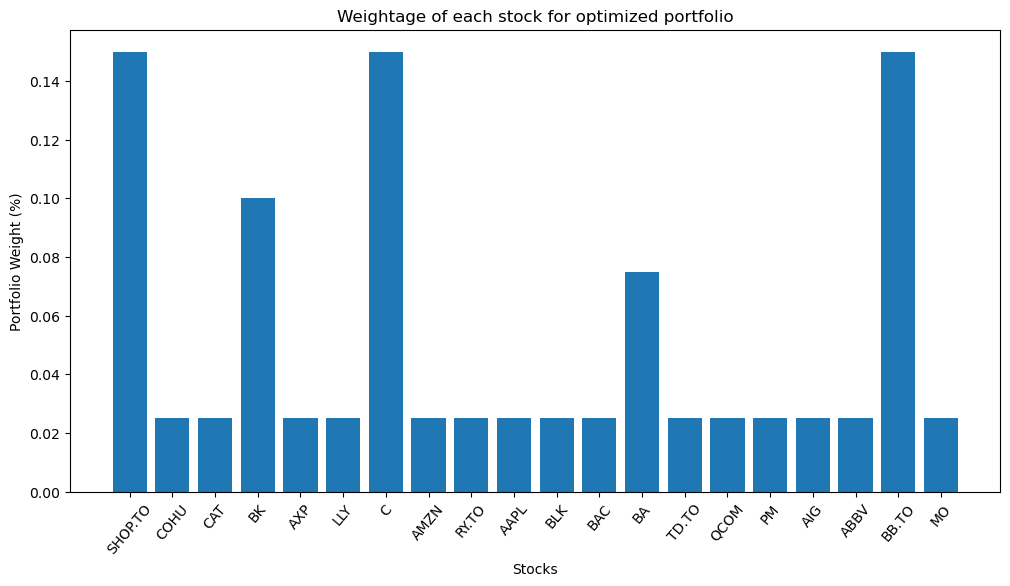

In [80]:
def plot_weight_distribution(tickers, weights):

    plt.figure(figsize=(12, 6))
    plt.bar(tickers, weights)
    plt.xticks(rotation = 50)
    plt.xlabel('Stocks')
    plt.ylabel('Portfolio Weight (%)')
    plt.title('Weightage of each stock for optimized portfolio')
    plt.show()

plot_weight_distribution(optimal_stocks, optimal_weighting)

Industry Breakdown (Counts):
Technology: 5
Industrials: 2
Financial Services: 8
Healthcare: 2
Consumer Cyclical: 1
Consumer Defensive: 2


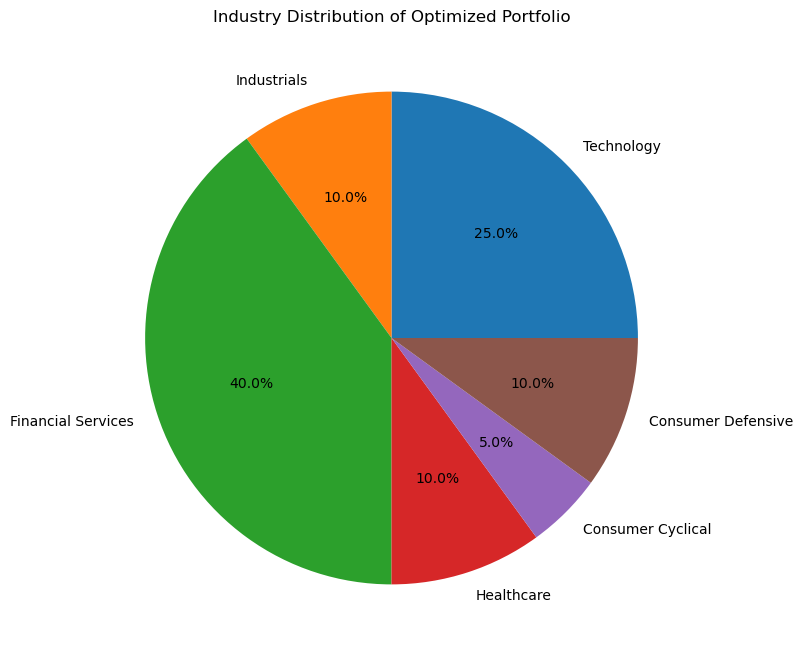

In [79]:
def plot_industry_distribution(tickers, ticker_dict):

    # Count industries
    industry_counts = {}
    for t in tickers:
        industry = ticker_dict[t][0]  # sector is index 0
        industry_counts[industry] = industry_counts.get(industry, 0) + 1

    # Print results
    print("Industry Breakdown (Counts):")
    for ind, count in industry_counts.items():
        print(f"{ind}: {count}")

    # Build pie chart
    labels = list(industry_counts.keys())
    sizes = list(industry_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes,
        labels=labels,
        autopct="%1.1f%%",
    )
        
    plt.title("Industry Distribution of Optimized Portfolio")
    plt.show()

    
plot_industry_distribution(optimal_stocks, ticker_dict)


In [61]:
# store the data so we can find the number of shares without fees deducted
optimal_portfolio_data = portfolio_returns(optimal_stocks, optimal_weighting, CAD_INITIAL_INVESTMENT)
optimal_portfolio_num_shares = optimal_portfolio_data[2]
# Divide by Exchange Rate to get from USD to CAD as our entire portfolio is in terms of CAD
fees = min(2.15/EXCHANGE_RATE, (0.001/EXCHANGE_RATE)*optimal_portfolio_num_shares)
# find how much we actually have in our portfolio after fees
actual_portfolio_investment = CAD_INITIAL_INVESTMENT - fees
actual_portfolio_investment



999996.9693169064

In [62]:
print("Number of weights:", len(optimal_weighting))
print("Number of stocks:", len(optimal_stocks))
print("All weights:", optimal_weighting)
print("All stocks:", optimal_stocks)

Number of weights: 20
Number of stocks: 20
All weights: [0.15  0.025 0.025 0.15  0.025 0.025 0.15  0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.15  0.025]
All stocks: ['SHOP.TO', 'COHU', 'CAT', 'BK', 'AXP', 'LLY', 'C', 'AMZN', 'RY.TO', 'AAPL', 'BLK', 'BAC', 'BA', 'TD.TO', 'QCOM', 'PM', 'AIG', 'ABBV', 'BB.TO', 'MO']


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Insert Names Here.
- Richard Meng
- Avaansh Nanda
- Devesh Kotak